<a href="https://colab.research.google.com/github/AnirbanDatta87/Kaggle/blob/master/Pneumonia_Detection_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RSNA Pneumonia Detection Challenge
---

**Problem Statement**

In this capstone project, the goal is to build a pneumonia detection system, to locate the position of inflammation in an image. Specifically, your algorithm needs to automatically locate lung opacities on chest radiographs. Tissues with sparse material, such as lungs which are full of air, do not absorb the X-rays and appear black in the image. Dense tissues such as bones absorb X-rays and appear white in the image. While we are theoretically detecting “lung opacities”, there are lung opacities that are not pneumonia related. In the data, some of these are labeled “Not Normal No Lung Opacity”. This extra third class indicates that while pneumonia was determined not to be present, there was nonetheless some type of abnormality on the image and oftentimes this finding may mimic the appearance of true pneumonia.

**Dicom original images**

Medical images are stored in a special format called DICOM files (*.dcm). They contain a combination of header metadata as well as underlying raw image arrays for pixel data.

**Here’s the backstory and why solving this problem matters**

* Pneumonia is the single largest infectious cause of death in children worldwide.
* In 2015, 920,000 children under the age of 5 died from the disease. In the United States, pneumonia accounts for over 500,000 visits to emergency departments and over 50,000 deaths in 2015, keeping the ailment on the list of top 10 causes of death in the country.
* Pneumonia killed 808 694 children under the age of 5 in 2017, accounting for 15% of all deaths of children under five years old. Pneumonia affects children and families everywhere but is most prevalent in South Asia and sub-Saharan Africa.
* Pneumonia can range in seriousness from mild to life-threatening. It is most serious for infants and young children, people older than age 65, and people with health problems or weakened immune systems. Pneumonia caused by bacteria can be treated with antibiotics, but only one third of children with pneumonia receive the antibiotics they need.
* It requires review of a chest radiograph (CXR) by highly trained specialists and confirmation through clinical history, vital signs and laboratory exams. Pneumonia usually manifests as an area or areas of increased opacity on CXR. However, the diagnosis of pneumonia on CXR is complicated because of a number of other conditions in the lungs such as fluid overload (pulmonary edema), bleeding, volume loss (atelectasis or collapse), lung cancer, or post-radiation or surgical changes. Outside of the lungs, fluid in the pleural space (pleural effusion) also appears as increased opacity on CXR. When available, comparison of CXRs of the patient taken at different time points and correlation with clinical symptoms and history are helpful in making the diagnosis.
* CXRs are the most commonly performed diagnostic imaging study. A number of factors such as positioning of the patient and depth of inspiration can alter the appearance of the CXR, complicating interpretation further. In addition, clinicians are faced with reading high volumes of images every shift.


Data Source: https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data

Reference: https://www.who.int/news-room/fact-sheets/detail/pneumonia

# Loading the Dataset and Libraries

### Installing pydicom for reading DICOM files

In [ ]:
!pip install pydicom

     |████████████████████████████████| 1.9MB 10.6MB/s 


### Importing libraries

In [ ]:
import numpy as np
import pydicom
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import multiprocessing
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.3f' % x)
sns.set_style('whitegrid')
sns.set_context('notebook')
plt.rcParams['figure.figsize'] = [14, 8]
plt.rcParams['lines.linewidth'] = 2.5

### Mount the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


### Change the directlry path

In [ ]:
import os
path = '/content/drive/MyDrive/Colab Notebooks/GL-AIML/Capstone Project'
os.chdir(path)
!pwd

/content/drive/MyDrive/Colab Notebooks/GL-AIML/Capstone Project


In [ ]:
ls

'Capstone -Pneumonia Detection Challenge - 1.ipynb'
'Capstone -Pneumonia Detection Challenge.ipynb'
 Create_images.ipynb
 dataset_images/
 EDA.ipynb
'GCP Credits Request Link - RSNA.txt'
 Mixed_link_model.h5
 rsna-pneumonia-detection-challenge.zip
 stage_2_detailed_class_info.csv
 stage_2_sample_submission.csv
 stage_2_test_images/
 stage_2_train_images/
 stage_2_train_labels.csv
 train_class_aug_df.csv


In [ ]:
# from zipfile import ZipFile
# with ZipFile('rsna-pneumonia-detection-challenge.zip','r') as z:
#     z.extractall()

### Read CSV files

In [ ]:
class_info_df = pd.read_csv('stage_2_detailed_class_info.csv')
train_labels_df = pd.read_csv('stage_2_train_labels.csv')

In [ ]:
train_labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


* The dataset is of shape (30227,6).
* All the columns instead of patientId column are read as numeric column (either float or int).
* Continuous columns : x, y, width, height.
* Categorical columns : Target

In [ ]:
class_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   patientId  30227 non-null  object
 1   class      30227 non-null  object
dtypes: object(2)
memory usage: 472.4+ KB


In [ ]:
print(f"Detailed class info -  rows: {class_info_df.shape[0]}, columns: {class_info_df.shape[1]}")
print(f"Train labels -  rows: {train_labels_df.shape[0]}, columns: {train_labels_df.shape[1]}")

Detailed class info -  rows: 30227, columns: 2
Train labels -  rows: 30227, columns: 6


Let's explore the two loaded files. We will take out a 5 rows samples from each dataset.

In [ ]:
class_info_df.sample(5)

patientId                         class
25470  e4373be2-37fe-4bd6-ae16-4f036375cf94  No Lung Opacity / Not Normal
2360   3173b82f-569b-43e6-aecc-b4fb6a14466f                  Lung Opacity
15281  958cb48f-1343-41c0-a674-b6e455ad7299                        Normal
18252  aca5cb44-9cfc-420b-a0c4-19f9ef692afb                  Lung Opacity
10801  71ea9683-d7a2-4613-9838-e0ec52a3e76a                        Normal

In [ ]:
train_labels_df.sample(5)

patientId       x  ...  height  Target
19803  b70a7d7e-3e11-4a74-998f-67eabfa438df 305.000  ... 172.000       1
15893  9a5dc526-bb32-4582-8bac-835625bdd2a4     nan  ...     nan       0
3616   39895c94-84ec-46b6-8a39-f57c99abdbca 236.000  ... 254.000       1
5679   48d473f6-a2f5-43a8-ac85-9929e2e7bc40     nan  ...     nan       0
27438  f3b015ab-e337-4e7f-971d-eb7cc3dd4e92     nan  ...     nan       0

[5 rows x 6 columns]

In [ ]:
print('Number of rows (unique boxes per patient) in main train dataset:', train_labels_df.shape[0])
print('Number of unique patient IDs:', train_labels_df['patientId'].nunique())

Number of rows (unique boxes per patient) in main train dataset: 30227
Number of unique patient IDs: 26684


In **class detailed info** dataset are given the detailed information about the type of positive or negative class associated with a certain patient.

In **train labels** dataset are given the patient ID and the window (x min, y min, width and height of the bounding box containing evidence of pneumonia.)

# Exploratory Data Analysis
Let's explore the data further.

## Missing data
Let's check missing information in the two datasets.

In [ ]:
def missing_data(data):
  total = data.isnull().sum().sort_values(ascending = False)
  percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
  return np.transpose(pd.concat([total, percent], axis=1, keys=['Total', 'Percent']))

In [ ]:
missing_data(train_labels_df)

height     width         y         x  Target  patientId
Total   20672.000 20672.000 20672.000 20672.000   0.000      0.000
Percent    68.389    68.389    68.389    68.389   0.000      0.000

In [ ]:
missing_data(class_info_df)

class  patientId
Total    0.000      0.000
Percent  0.000      0.000

The percent missing for x,y, height and width in train labels represents the percent of the target 0 (not Lung opacity).

Let's check the class distribution from class detailed info.

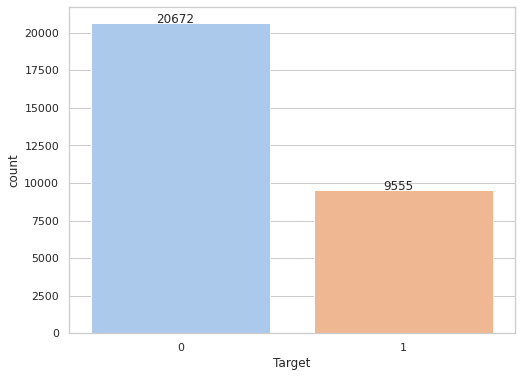

In [ ]:
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['lines.linewidth'] = 1.5

def countPlot(target="Target"):
    ax = sns.countplot(x=target, data=train_labels_df, palette="pastel")

    for p in ax.patches:
        ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.375, p.get_height()+0.15), ha='center')

    plt.show()

countPlot("Target")

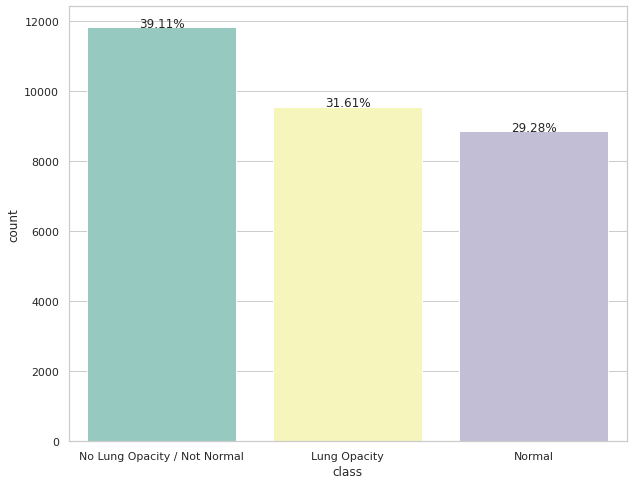

In [ ]:
f, ax = plt.subplots(1,1, figsize=(10,8))
total = float(len(class_info_df))
sns.countplot(class_info_df['class'],order = class_info_df['class'].value_counts().index, palette='Set3')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 6,
            '{:1.2f}%'.format(100*height/total),
            ha="center") 
plt.show()

Let's look into more details to the classes.

In [ ]:
def get_feature_distribution(data, feature):
    # Get the count for each label
    label_counts = data[feature].value_counts()

    # Get total number of samples
    total_samples = len(data)

    # Count the number of items in each class
    print("Feature: {}".format(feature))
    for i in range(len(label_counts)):
        label = label_counts.index[i]
        count = label_counts.values[i]
        percent = int((count / total_samples) * 10000) / 100
        print("{:<30s}:   {} or {}%".format(label, count, percent))

get_feature_distribution(class_info_df, 'class')

Feature: class
No Lung Opacity / Not Normal  :   11821 or 39.1%
Lung Opacity                  :   9555 or 31.61%
Normal                        :   8851 or 29.28%


**No Lung Opacity / Not Normal** and **Normal** have together the same percent (69.077%) as the percent of missing values for target window in class details information.

In the train set, the percent of data with value for Target = 1 is therefore 30.92%.

## Merge train and class detail info data
Let's merge now the two datasets, using Patient ID as the merge criteria.

In [ ]:
assert train_labels_df['patientId'].values.tolist() == class_info_df['patientId'].values.tolist(), 'PatientId columns are different.'
train_class_df = pd.concat([train_labels_df, class_info_df.drop(labels=['patientId'], axis=1)], axis=1)
train_class_df.shape

(30227, 7)

In [ ]:
train_class_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
 6   class      30227 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 1.6+ MB


## Target and class
Let's plot the number of examinations for each class detected, grouped by Target value.

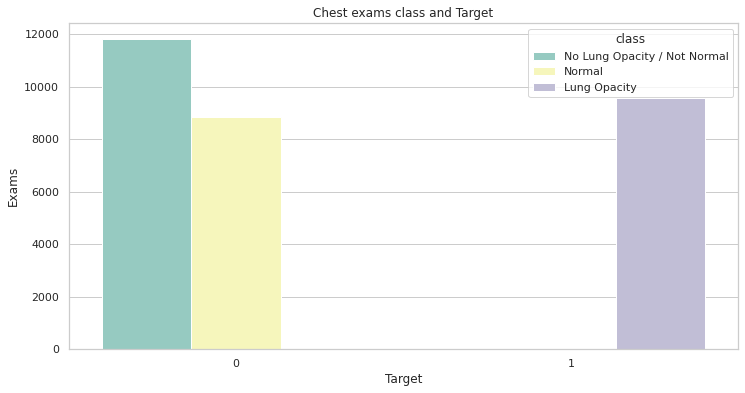

In [ ]:
fig, ax = plt.subplots(nrows=1,figsize=(12,6))
tmp = train_class_df.groupby('Target')['class'].value_counts()
df = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index()
sns.barplot(ax=ax,x = 'Target', y='Exams',hue='class',data=df, palette='Set3')
plt.title("Chest exams class and Target")
plt.show()

All chest examinations with **Target = 1** (pathology detected) associated with class: **Lung Opacity**.

The chest examinations with **Target = 0** (no pathology detected) are either of class: **Normal** or class: **No Lung Opacity / Not Normal**.

## Detected Lung Opacity window
For the class Lung Opacity, corresponding to values of Target = 1, we plot the density of x, y, width and height.

<Figure size 576x432 with 0 Axes>

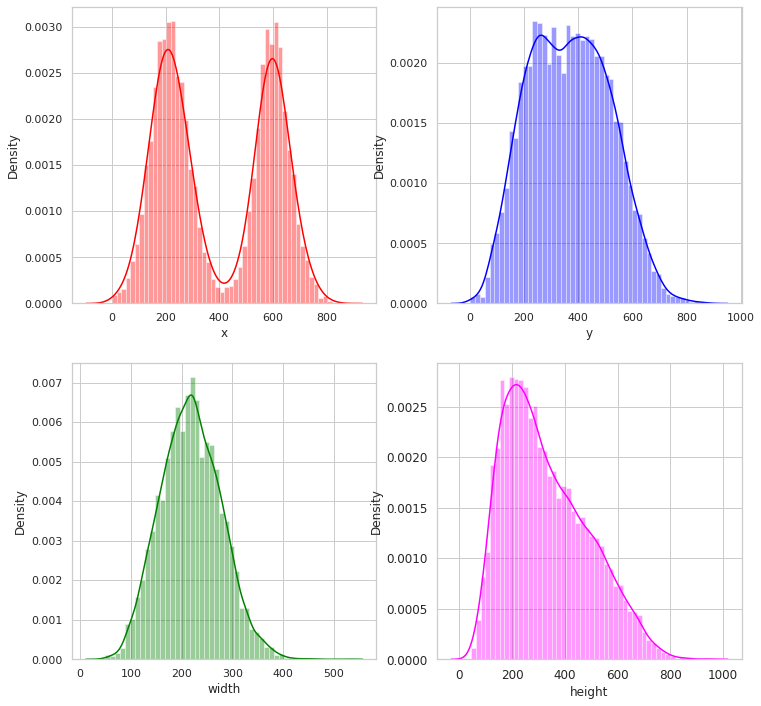

In [ ]:
target1 = train_class_df[train_class_df['Target']==1]
sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(2,2,figsize=(12,12))
sns.distplot(target1['x'],kde=True,bins=50, color="red", ax=ax[0,0])
sns.distplot(target1['y'],kde=True,bins=50, color="blue", ax=ax[0,1])
sns.distplot(target1['width'],kde=True,bins=50, color="green", ax=ax[1,0])
sns.distplot(target1['height'],kde=True,bins=50, color="magenta", ax=ax[1,1])
locs, labels = plt.xticks()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

We can plot also the center of the rectangles points in the plane x0y. The centers of the rectangles are the points: 
$x_{c} = x + \frac{width}{2}$ and $y_{c} = y + \frac{height}{2}$.

We will show a sample of center points superposed with the corresponding sample of the rectangles.

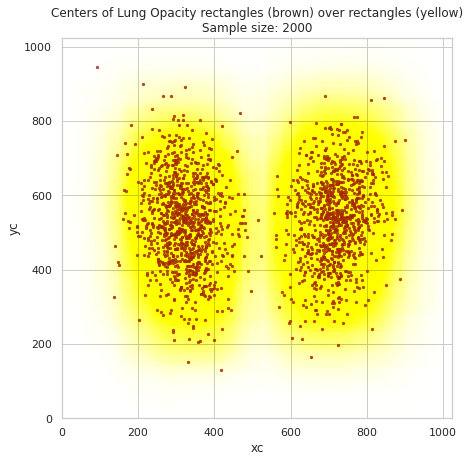

In [ ]:
from matplotlib.patches import Rectangle
fig, ax = plt.subplots(1,1,figsize=(7,7))
target_sample = target1.sample(2000)
target_sample['xc'] = target_sample['x'] + target_sample['width'] / 2
target_sample['yc'] = target_sample['y'] + target_sample['height'] / 2
plt.title("Centers of Lung Opacity rectangles (brown) over rectangles (yellow)\nSample size: 2000")
target_sample.plot.scatter(x='xc', y='yc', xlim=(0,1024), ylim=(0,1024), ax=ax, alpha=0.8, marker=".", color="brown")
for i, crt_sample in target_sample.iterrows():
    ax.add_patch(Rectangle(xy=(crt_sample['x'], crt_sample['y']),
                width=crt_sample['width'],height=crt_sample['height'],alpha=3.5e-3, color="yellow"))
plt.show()

## Where are all the Lung Opacities located?

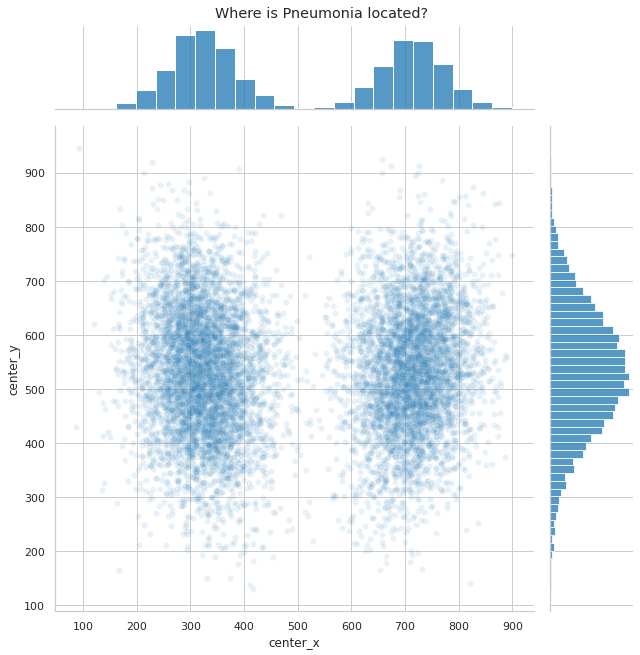

In [ ]:
tr = train_class_df[train_class_df['Target']==1]
centers = (tr.dropna(subset=['x'])
           .assign(center_x=tr.x + tr.width / 2, center_y=tr.y + tr.height / 2))
ax = sns.jointplot("center_x", "center_y", data=centers, height=9, alpha=0.1)
_ = ax.fig.suptitle("Where is Pneumonia located?", y=1.01)

## Where are the outlier points located?

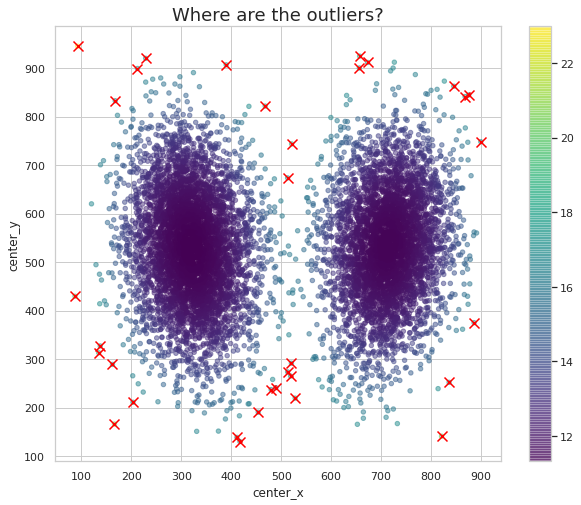

In [ ]:
from sklearn.mixture import GaussianMixture
clf = GaussianMixture(n_components=2)
clf.fit(centers[['center_x', 'center_y']])
center_probs = clf.predict_proba(centers[['center_x', 'center_y']])
Z = -clf.score_samples(centers[['center_x', 'center_y']])
outliers = centers.iloc[Z > 17]
fig, ax = plt.subplots(1,1,figsize=(10,8))
centers.plot.scatter('center_x', 'center_y', c=Z, alpha=0.5, cmap='viridis', ax=ax)
outliers.plot.scatter('center_x', 'center_y', c='red', marker='x', s=100, ax=ax)
_ = ax.set_title('Where are the outliers?', fontsize=18)

## Exploring DICOM Data

In [ ]:
image_sample_path = os.listdir('stage_2_train_images')[:5]
print(image_sample_path)

['f79e5a75-5e15-431a-9ba3-de64c1724b65.dcm', 'f79fa94e-8886-425c-95d4-81abfea92aee.dcm', 'f79fc759-fde0-4e2e-8951-26ac8af5ef89.dcm', 'f7a169e2-a1a7-439a-ab83-0d34cf5ae4b9.dcm', 'f7a172fc-a34f-4155-806d-7b0afe2a6156.dcm']


In [ ]:
image_train_path = os.listdir('stage_2_train_images')
image_test_path = os.listdir('stage_2_test_images')
print("Number of images in train set:", len(image_train_path),"\nNumber of images in test set:", len(image_test_path))

Number of images in train set: 26684 
Number of images in test set: 3000


In [ ]:
print("Unique patientId in  train_class_df: ", train_class_df['patientId'].nunique()) 

Unique patientId in  train_class_df:  26684


We confirmed that the number of unique patientsId are equal with the number of DICOM images in the train set.

Let's see what entries are duplicated. We want to check how are these distributed accross classes and Target value.

In [ ]:
tmp = train_class_df.groupby(['patientId','Target', 'class'])['patientId'].count()
df = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index()
tmp = df.groupby(['Exams','Target','class']).count()
df2 = pd.DataFrame(data=tmp.values, index=tmp.index).reset_index()
df2.columns = ['Exams', 'Target','Class', 'Entries']
df2

Exams  Target                         Class  Entries
0      1       0  No Lung Opacity / Not Normal    11821
1      1       0                        Normal     8851
2      1       1                  Lung Opacity     2614
3      2       1                  Lung Opacity     3266
4      3       1                  Lung Opacity      119
5      4       1                  Lung Opacity       13

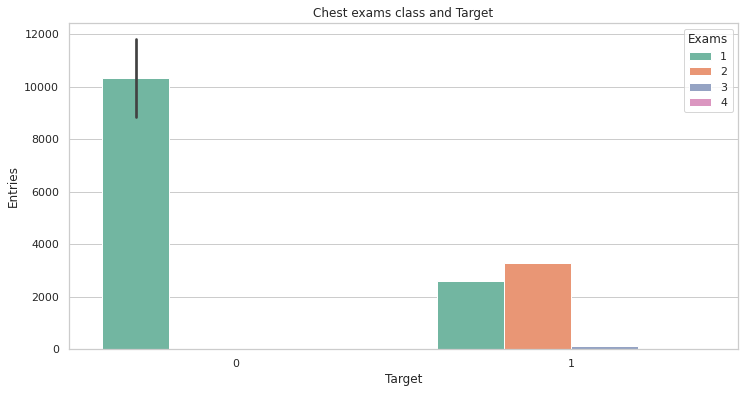

In [ ]:
fig, ax = plt.subplots(nrows=1,figsize=(12,6))
sns.barplot(ax=ax,x = 'Target', y='Entries', hue='Exams',data=df2, palette='Set2')
plt.title("Chest exams class and Target")
plt.show()

Let's now extract one image and process the DICOM information.

In [ ]:
import pydicom as dcm

samplePatientID = list(train_class_df[:3].T.to_dict().values())[0]['patientId']
samplePatientID = samplePatientID+'.dcm'
dicom_file_path = os.path.join("stage_2_train_images/",samplePatientID)
dicom_file_dataset = dcm.read_file(dicom_file_path)
dicom_file_dataset

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

In [ ]:
def show_dicom_images(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3,3, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']+'.dcm'
        imagePath = os.path.join("stage_2_train_images/",patientImage)
        data_row_img_data = dcm.read_file(imagePath)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = dcm.dcmread(imagePath)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nClass: {}\nWindow: {}:{}:{}:{}'.format(
                data_row['patientId'],
                modality, age, sex, data_row['Target'], data_row['class'], 
                data_row['x'],data_row['y'],data_row['width'],data_row['height']))
    plt.show()

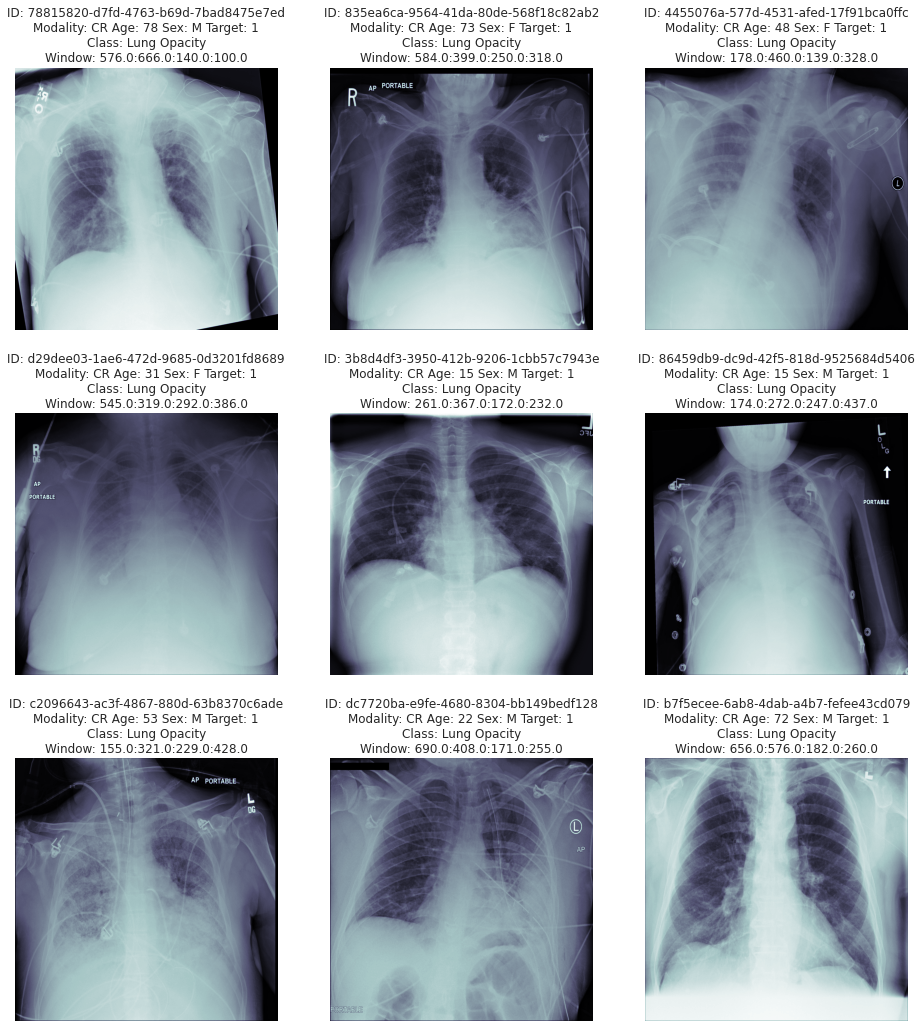

In [ ]:
show_dicom_images(train_class_df[train_class_df['Target']==1].sample(9))

In [ ]:
def show_dicom_images_with_boxes(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3,3, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']+'.dcm'
        imagePath = os.path.join("stage_2_train_images/",patientImage)
        data_row_img_data = dcm.read_file(imagePath)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = dcm.dcmread(imagePath)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nClass: {}'.format(
                data_row['patientId'],modality, age, sex, data_row['Target'], data_row['class']))
        rows = train_class_df[train_class_df['patientId']==data_row['patientId']]
        box_data = list(rows.T.to_dict().values())
        for j, row in enumerate(box_data):
            ax[i//3, i%3].add_patch(Rectangle(xy=(row['x'], row['y']),
                        width=row['width'],height=row['height'], 
                        color="yellow",alpha = 0.1))   
    plt.show()

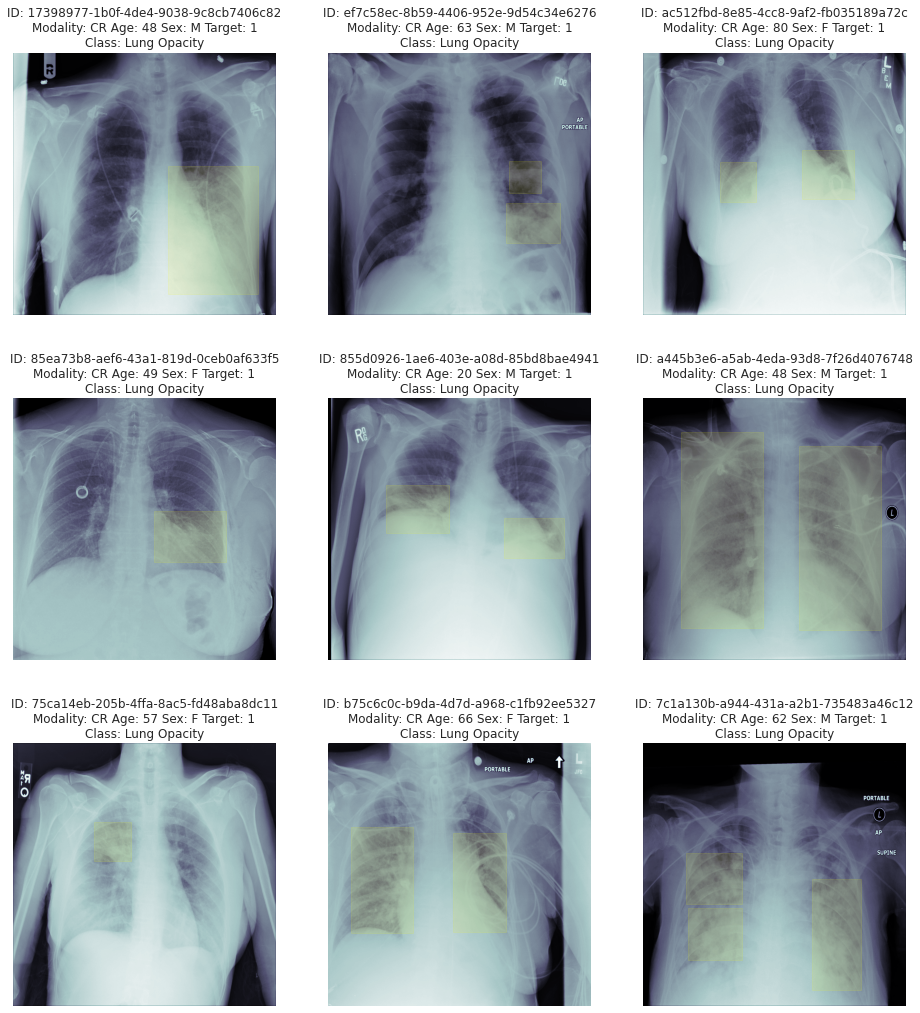

In [ ]:
show_dicom_images_with_boxes(train_class_df[train_class_df['Target']==1].sample(9))

## Plot DICOM Images with target = 0

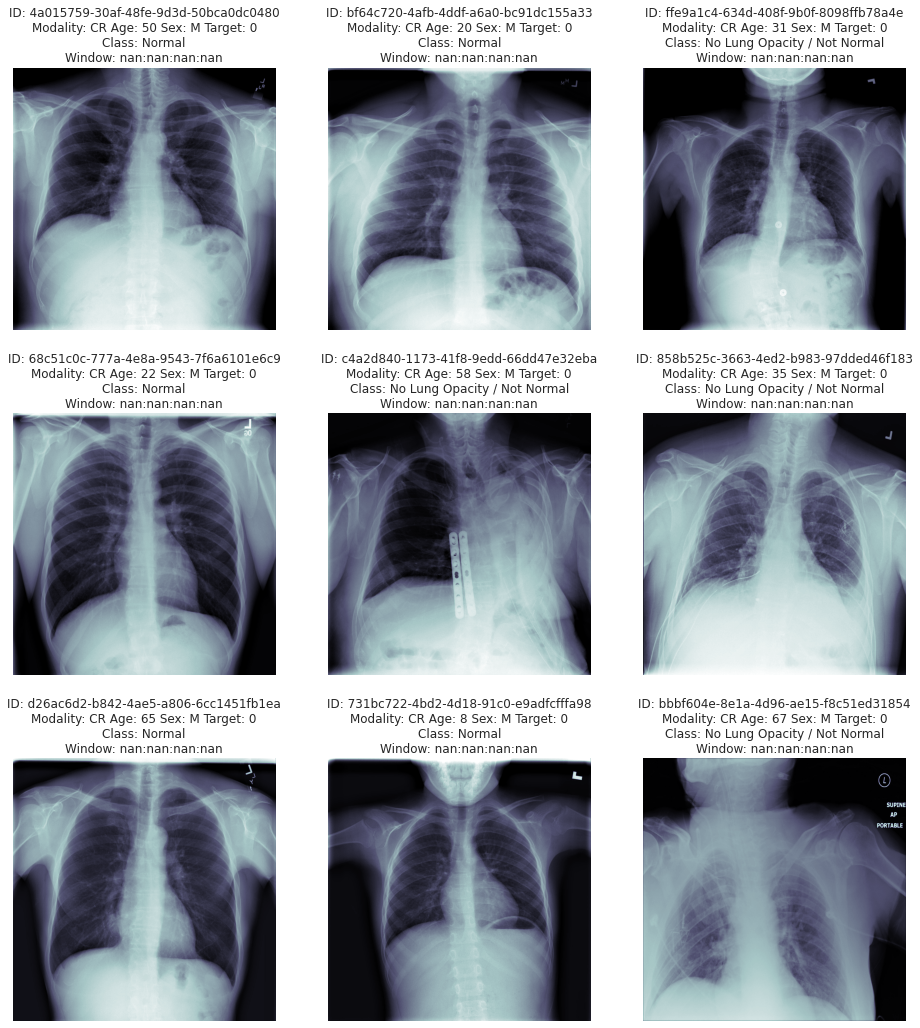

In [ ]:
show_dicom_images(train_class_df[train_class_df['Target']==0].sample(9))

## Add meta information from DICOM Data

In [ ]:
# PATH = ''
# vars = ['Modality', 'PatientAge', 'PatientSex', 'BodyPartExamined', 'ViewPosition', 'ConversionType', 'Rows', 'Columns', 'PixelSpacing']

# def process_dicom_data(data_df, data_path):
#     for var in vars:
#         data_df[var] = None
#     image_names = os.listdir(PATH+data_path)
#     for i, img_name in tqdm_notebook(enumerate(image_names)):
#         imagePath = os.path.join(PATH,data_path,img_name)
#         data_row_img_data = dcm.read_file(imagePath)
#         idx = (data_df['patientId']==data_row_img_data.PatientID)
#         data_df.loc[idx,'Modality'] = data_row_img_data.Modality
#         data_df.loc[idx,'PatientAge'] = pd.to_numeric(data_row_img_data.PatientAge)
#         data_df.loc[idx,'PatientSex'] = data_row_img_data.PatientSex
#         data_df.loc[idx,'BodyPartExamined'] = data_row_img_data.BodyPartExamined
#         data_df.loc[idx,'ViewPosition'] = data_row_img_data.ViewPosition
#         data_df.loc[idx,'ConversionType'] = data_row_img_data.ConversionType
#         data_df.loc[idx,'Rows'] = data_row_img_data.Rows
#         data_df.loc[idx,'Columns'] = data_row_img_data.Columns  
#         data_df.loc[idx,'PixelSpacing'] = str.format("{:4.3f}",data_row_img_data.PixelSpacing[0])

In [ ]:
# process_dicom_data(train_class_df,'stage_2_train_images/')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [ ]:
# train_class_df.sample(5)

patientId      x  ...  Columns  PixelSpacing
5561   3bb9b9b3-b086-4083-ae6f-d1f86c3eb089  579.0  ...     1024         0.171
17845  8dad1a61-dbab-4f1b-a71f-a0a9237b0e2a    NaN  ...     1024         0.168
25930  bb7973b1-58b1-4e2e-b687-144e179f0996  666.0  ...     1024         0.139
15840  8103ed5c-d55f-4f35-9ddc-83e71ec76ab4    NaN  ...     1024         0.143
33122  ed09e414-bcdd-4342-aab8-3b286a54facf  186.0  ...     1024         0.168

[5 rows x 16 columns]

In [ ]:
# train_class_df.name = 'train_class_aug_df'
# train_class_df.csv_path = 'train_class_aug_df.csv'
# train_class_df.to_csv(train_class_df.csv_path)

In [ ]:
# test_class_df = pd.read_csv('stage_2_sample_submission.csv')
# test_class_df.sample(5)

patientId PredictionString
2261  29f4ade7-a785-419f-8d39-9c7d57f3a296  0.5 0 0 100 100
983   143cc465-80b8-484c-ba71-ad362ea8fd90  0.5 0 0 100 100
2071  27161478-e5ca-40aa-98f6-777a59e96200  0.5 0 0 100 100
718   1143fdaa-99cb-437d-88de-0a9299bf8e40  0.5 0 0 100 100
163   027301a0-cb61-4431-8736-503d0c23cd48  0.5 0 0 100 100

In [ ]:
# test_class_df = test_class_df.drop('PredictionString',1)
# process_dicom_data(test_class_df,'stage_2_test_images/')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [ ]:
# test_class_df.name = 'test_class_aug_df'
# test_class_df.csv_path = 'test_class_aug_df.csv'
# test_class_df.to_csv(test_class_df.csv_path)

In [ ]:
train_class_df = pd.read_csv('train_class_aug_df.csv')
test_class_df = pd.read_csv('test_class_aug_df.csv')
print(train_class_df.shape)
print(test_class_df.shape)

(37629, 17)
(3000, 11)


## Modality
Let's check how many modalities are used. Both train and test set are checked.

In [ ]:
print("Modalities: train:",train_class_df['Modality'].unique(), "test:", test_class_df['Modality'].unique())

Modalities: train: ['CR'] test: ['CR']


The meaning of this modality is CR - Computer Radiography. 

## Body Part Examined
Let's check if other body parts than 'CHEST' appears in the data.

In [ ]:
print("Body Part Examined: train:",train_class_df['BodyPartExamined'].unique(), "test:", test_class_df['BodyPartExamined'].unique())

Body Part Examined: train: ['CHEST'] test: ['CHEST']


## View Position
View Position is a radiographic view associated with the Patient Position. Let's check the View Positions distribution for the both datasets.

In [ ]:
print("View Position: train:",train_class_df['ViewPosition'].unique(), "test:", test_class_df['ViewPosition'].unique())

View Position: train: ['PA' 'AP'] test: ['PA' 'AP']


## Train dataset
Let's get into more details for the train dataset. First, let's check the distribution of PA and AP.

In [ ]:
get_feature_distribution(train_class_df,'ViewPosition')

Feature: ViewPosition
AP                            :   21817 or 57.97%
PA                            :   15812 or 42.02%


Both AP and PA body positions are present in the data. The meaning of these view positions are:

* AP - Anterior/Posterior
* PA - Posterior/Anterior

Let's check, for the training data presenting Lung Opacity, the distribution of the window for both View Positions. We create a function to represent the distribution of the window centers and windows.

In [ ]:
def plot_window(data,color_point, color_window,text):
    fig, ax = plt.subplots(1,1,figsize=(7,7))
    plt.title("Centers of Lung Opacity rectangles over rectangles\n{}".format(text))
    data.plot.scatter(x='xc', y='yc', xlim=(0,1024), ylim=(0,1024), ax=ax, alpha=0.8, marker=".", color=color_point)
    for i, crt_sample in data.iterrows():
        ax.add_patch(Rectangle(xy=(crt_sample['x'], crt_sample['y']),
            width=crt_sample['width'],height=crt_sample['height'],alpha=3.5e-3, color=color_window))
    plt.show()

We sample a subset of the train data with Target = 1. We calculate as well the center of the windows with Lung Opacity. We then select from this sample the data with the two view position, to plot the window distribution separately.

In [ ]:
target1 = train_class_df[train_class_df['Target']==1]

target_sample = target1.sample(2000)
target_sample['xc'] = target_sample['x'] + target_sample['width'] / 2
target_sample['yc'] = target_sample['y'] + target_sample['height'] / 2

target_ap = target_sample[target_sample['ViewPosition']=='AP']
target_pa = target_sample[target_sample['ViewPosition']=='PA']

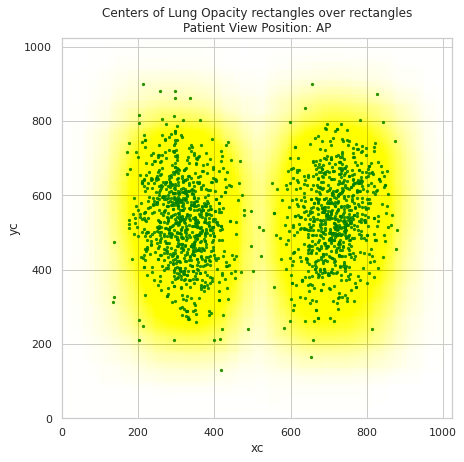

In [ ]:
plot_window(target_ap,'green', 'yellow', 'Patient View Position: AP')

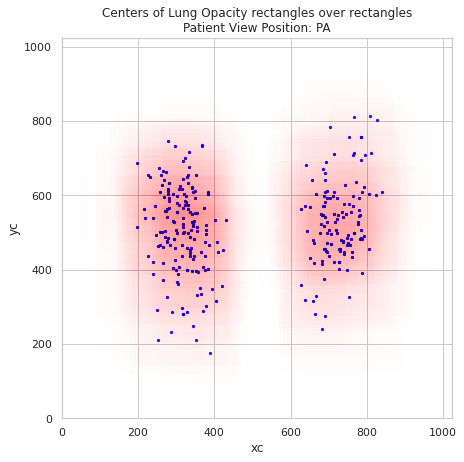

In [ ]:
plot_window(target_pa,'blue', 'red', 'Patient View Position: PA')

## Conversion Type
Let's check the Conversion Type data.

In [ ]:
print("Conversion Type: train:",train_class_df['ConversionType'].unique(), "test:", test_class_df['ConversionType'].unique())

Conversion Type: train: ['WSD'] test: ['WSD']


Both train and test have only WSD Conversion Type Data. The meaning of this Conversion Type is WSD: Workstation.

## Rows and Columns (Pixel Dimension)

In [ ]:
print("Rows: train:",train_class_df['Rows'].unique(), "test:", test_class_df['Rows'].unique())
print("Columns: train:",train_class_df['Columns'].unique(), "test:", test_class_df['Columns'].unique())

Rows: train: [1024] test: [1024]
Columns: train: [1024] test: [1024]


Only {Rows:Columns} {1024:1024} are present in both train and test

## Patient Age
Let's examine now the data for the Patient Age for the train set.

### Age Distribution by gender and Target

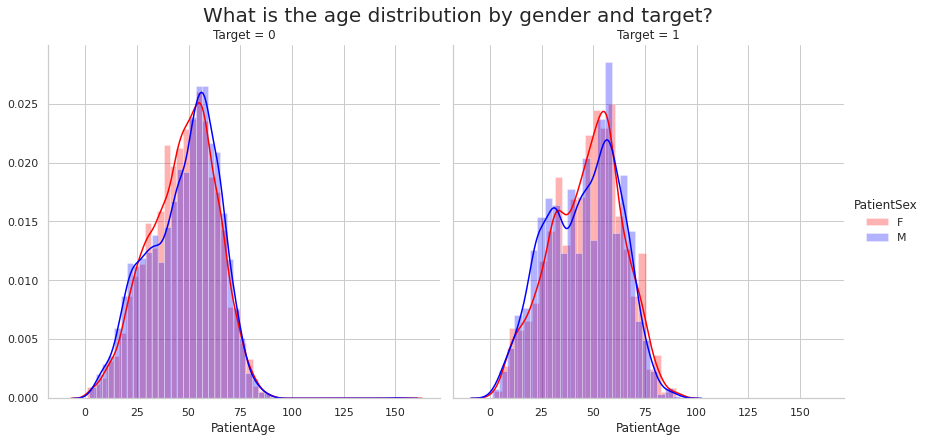

In [ ]:
g = sns.FacetGrid(col='Target', hue='PatientSex', 
                  data=train_class_df.drop_duplicates(subset=['patientId']), 
                  height=6, palette=dict(F="red", M="blue"))
_ = g.map(sns.distplot, 'PatientAge', hist_kws={'alpha': 0.3}).add_legend()
_ = g.fig.suptitle("What is the age distribution by gender and target?", y=1.02, fontsize=20)

# Model Building

Our CNN architecture stacks  4 convolutional layers (each one followed by a ReLU layer), then a pooling layer, then another few convolutional layers (+ReLU), then another pooling layer, and so on. The image gets smaller and smaller as it progresses through the network, but it also typically gets deeper and deeper (i.e., with more feature maps) thanks to the convolutional layers. At the top of the stack, a regular feedforward neural network is added, composed of a few fully connected layers (+ReLUs), and the final layer outputs the prediction (e.g., a softmax layer that outputs estimated class probabilities).

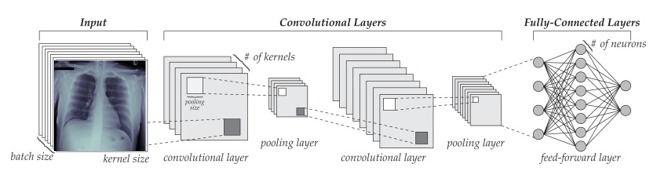

In [ ]:
import csv
import random
import pydicom
from skimage import io
from skimage import measure
from skimage.transform import resize

import tensorflow as tf
from tensorflow import keras

from matplotlib import pyplot as plt
import matplotlib.patches as patches

In [ ]:
# empty dictionary
PATH = ''
pneumonia_locations = {}
# load table
with open(os.path.join(PATH+'stage_2_train_labels.csv'), mode='r') as infile:
    # open reader
    reader = csv.reader(infile)
    # skip header
    next(reader, None)
    # loop through rows
    for rows in reader:
        # retrieve information
        filename = rows[0]
        location = rows[1:5]
        pneumonia = rows[5]
        # if row contains pneumonia add label to dictionary
        # which contains a list of pneumonia locations per filename
        if pneumonia == '1':
            # convert string to float to int
            location = [int(float(i)) for i in location]
            # save pneumonia location in dictionary
            if filename in pneumonia_locations:
                pneumonia_locations[filename].append(location)
            else:
                pneumonia_locations[filename] = [location]


In [ ]:
# load and shuffle filenames
folder = PATH+'stage_2_train_images'
filenames = os.listdir(folder)
random.shuffle(filenames)
# split into train and validation filenames
n_valid_samples = 2560
train_filenames = filenames[n_valid_samples:]
valid_filenames = filenames[:n_valid_samples]
print('n train samples', len(train_filenames))
print('n valid samples', len(valid_filenames))
n_train_samples = len(filenames) - n_valid_samples
print('Total train images:',len(filenames))
print('Images with pneumonia:', len(pneumonia_locations))


n train samples 24124
n valid samples 2560
Total train images: 26684
Images with pneumonia: 6012


In [ ]:
class generator(keras.utils.Sequence):
    
    def __init__(self, folder, filenames, pneumonia_locations=None, batch_size=32, image_size=256, shuffle=True, augment=False, predict=False):
        self.folder = folder
        self.filenames = filenames
        self.pneumonia_locations = pneumonia_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()
        
    def __load__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # create empty mask
        msk = np.zeros(img.shape)
        # get filename without extension
        filename = filename.split('.')[0]
        # if image contains pneumonia

        if filename in pneumonia_locations:
            # loop through pneumonia
            for location in pneumonia_locations[filename]:
                # add 1's at the location of the pneumonia
                x, y, w, h = location
                msk[y:y+h, x:x+w] = 1
        # if augment then horizontal flip half the time
        if self.augment and random.random() > 0.5:
            img = np.fliplr(img)
            msk = np.fliplr(msk)
        # resize both image and mask
        img = resize(img, (self.image_size, self.image_size), mode='symmetric')
        msk = resize(msk, (self.image_size, self.image_size), mode='symmetric') > 0.5
        img = np.array(img).astype(np.float32)
        msk = np.array(msk).astype(np.float32)
        
        

        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        msk = np.expand_dims(msk, -1)
        return img, msk
    
    def __loadpredict__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # resize image
        img = resize(img, (self.image_size, self.image_size), mode='symmetric')
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img
        
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            # unzip images and masks
            imgs, msks = zip(*items)
            # create numpy batch
            imgs = np.array(imgs)
            msks = np.array(msks)
            return imgs, msks
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

The ResNet is surprisingly simple. It starts and ends exactly like GoogLeNet (except without a dropout layer), and in between is just a very deep stack of simple residual units. Each residual unit is composed of two convolutional layers (and no pooling layer), with Batch Normalization (BN) and ReLU activation, using 3 × 3 kernels and preserving spatial dimensions (stride 1, SAME padding).

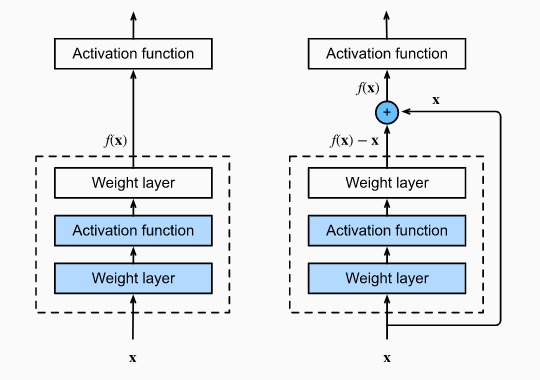

In [ ]:
def create_downsample(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
    x = keras.layers.MaxPool2D(2)(x)
    # Added start
    #x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
    #x = keras.layers.MaxPool2D(2)(x)
    # Added End
    return x


def create_resblock(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)

    #Added Start
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    #Added End
    
    addInput = x;
    print("Add input shape:", addInput.shape)
    print("Resnet block input shape:", inputs.shape)
    resBlockOut = keras.layers.add([addInput, inputs])
    print("Resnet block out shape:", resBlockOut.shape)
    out = keras.layers.concatenate([resBlockOut, addInput], axis=3)
    print("concat block out shape:", out.shape)
    out = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(out)
    print("mixed block out shape:", out.shape)
    return out

def create_network(input_size, channels, n_blocks=2, depth=4):
    # input
    inputs = keras.Input(shape=(input_size, input_size, 1))
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    # residual blocks
    for d in range(depth):
        channels = channels * 2
        x = create_downsample(channels, x)
        for b in range(n_blocks):
            x = create_resblock(channels, x)
    # output
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(1, 1, activation='sigmoid')(x)
    outputs = keras.layers.UpSampling2D(2**depth)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
# define iou or jaccard loss function
def iou_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

# combine bce loss and iou loss
def iou_bce_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * iou_loss(y_true, y_pred)

# mean iou as a metric
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

### Create train and validation generators

In [ ]:
folder = PATH+'stage_2_train_images'
train_gen = generator(folder, train_filenames[0:1000], pneumonia_locations, batch_size=16, image_size=128, shuffle=False, augment=True, predict=False)
valid_gen = generator(folder, valid_filenames[1000:1200], pneumonia_locations, batch_size=16, image_size=128, shuffle=False, predict=False)

### Create network and compiler with adam optimizer

Gradient descent optimization algorithms like stochastic gradient descent (SGD)
are most widely used to train neural networks. Recently, adaptive variants of
gradient methods like Adagrad, Adam etc. have caught popularity and are being
used by almost all the new architectures for training.Adam optimizer has become the de-facto standard for these algorithms.

Adam is an an algorithm for first-order gradient-based optimization of
stochastic objective functions, based on adaptive estimates of lower-order moments. The method is straightforward to implement, is computationally efficient,
has little memory requirements, is invariant to diagonal rescaling of the gradients,
and is well suited for problems that are large in terms of data and/or parameters.



In [ ]:
model = create_network(input_size=128, channels=16, n_blocks=2, depth=3)
model.compile(optimizer='adam',
              loss=iou_bce_loss,
              metrics=['accuracy', mean_iou])
print("model summary:", model.summary())
# cosine learning rate annealing
def cosine_annealing(x):
    lr = 0.001
    epochs = 25
    return lr*(np.cos(np.pi*x/epochs)+1.)/2
learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)

Add input shape: (None, 64, 64, 32)
Resnet block input shape: (None, 64, 64, 32)
Resnet block out shape: (None, 64, 64, 32)
concat block out shape: (None, 64, 64, 64)
mixed block out shape: (None, 64, 64, 32)
Add input shape: (None, 64, 64, 32)
Resnet block input shape: (None, 64, 64, 32)
Resnet block out shape: (None, 64, 64, 32)
concat block out shape: (None, 64, 64, 64)
mixed block out shape: (None, 64, 64, 32)
Add input shape: (None, 32, 32, 64)
Resnet block input shape: (None, 32, 32, 64)
Resnet block out shape: (None, 32, 32, 64)
concat block out shape: (None, 32, 32, 128)
mixed block out shape: (None, 32, 32, 64)
Add input shape: (None, 32, 32, 64)
Resnet block input shape: (None, 32, 32, 64)
Resnet block out shape: (None, 32, 32, 64)
concat block out shape: (None, 32, 32, 128)
mixed block out shape: (None, 32, 32, 64)
Add input shape: (None, 16, 16, 128)
Resnet block input shape: (None, 16, 16, 128)
Resnet block out shape: (None, 16, 16, 128)
concat block out shape: (None, 16, 

#### Fit the model

In [ ]:
# train_gen = generator(folder, train_filenames, pneumonia_locations, batch_size=16, image_size=128, shuffle=False, augment=True, predict=False)
# valid_gen = generator(folder, valid_filenames, pneumonia_locations, batch_size=16, image_size=128, shuffle=False, predict=False)

history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate], epochs=10, shuffle=True, verbose=2)

#history = model.fit_generator(train_gen, callbacks=[learning_rate], epochs=25, workers=4, use_multiprocessing=True)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
62/62 - 746s - loss: 0.5748 - accuracy: 0.9349 - mean_iou: 0.5444 - val_loss: 0.5395 - val_accuracy: 0.9617 - val_mean_iou: 0.3119
Epoch 2/10
62/62 - 158s - loss: 0.5140 - accuracy: 0.9606 - mean_iou: 0.5465 - val_loss: 0.5380 - val_accuracy: 0.9214 - val_mean_iou: 0.4881
Epoch 3/10
62/62 - 159s - loss: 0.4997 - accuracy: 0.9602 - mean_iou: 0.5711 - val_loss: 0.4946 - val_accuracy: 0.9605 - val_mean_iou: 0.5803
Epoch 4/10
62/62 - 161s - loss: 0.4872 - accuracy: 0.9618 - mean_iou: 0.5973 - val_loss: 0.5015 - val_accuracy: 0.9441 - val_mean_iou: 0.6034
Epoch 5/10
62/62 - 164s - loss: 0.4855 - accuracy: 0.9613 - mean_iou: 0.6067 - val_loss: 0.5137 - val_accuracy: 0.9635 - val_mean_iou: 0.5740
Epoch 6/10
62/62 - 163s - loss: 0.4702 - accuracy: 0.9624 - mean_iou: 0.6299 - val_loss: 0.4729 - val_accuracy: 0.9595 - val_mean_iou: 0.6029
Epoch 7/10
62/62 - 163s - loss: 0.4664 - accuracy: 0.9634 - mean_iou: 0.

#### Plot the graphs

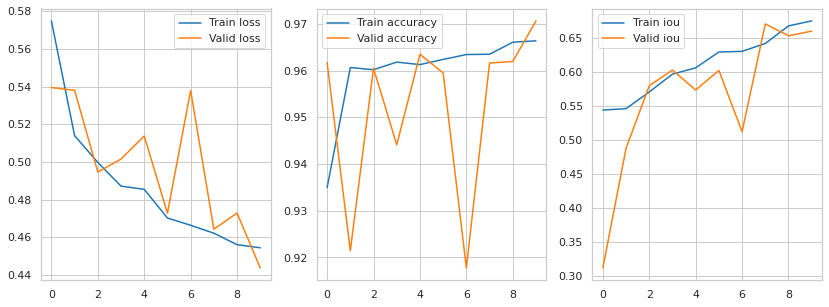

In [ ]:
plt.figure(figsize=(14,5))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["accuracy"], label="Train accuracy")
plt.plot(history.epoch, history.history["val_accuracy"], label="Valid accuracy")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["mean_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_mean_iou"], label="Valid iou")
plt.legend()
plt.show()

#### Save the model

In [ ]:
model.save(r'Mixed_link_model.h5')

In [ ]:
adm_accuracy = round(history.history.get('accuracy')[-1] * 100, 2)
adm_val_accuracy = round(history.history.get('val_accuracy')[-1] * 100, 2)
adm_loss = round(history.history.get('loss')[-1] * 100, 2)
adm_val_loss = round(history.history.get('val_loss')[-1] * 100, 2)
adm_mean_iou = round(history.history.get('mean_iou')[-1] * 100, 2)
adm_val_mean_iou = round(history.history.get('val_mean_iou')[-1] * 100, 2)
print(adm_accuracy, adm_val_accuracy, adm_loss, adm_val_loss, adm_mean_iou, adm_val_mean_iou)

96.64 97.06 45.45 44.38 67.58 66.07


#### Predict a batch of images

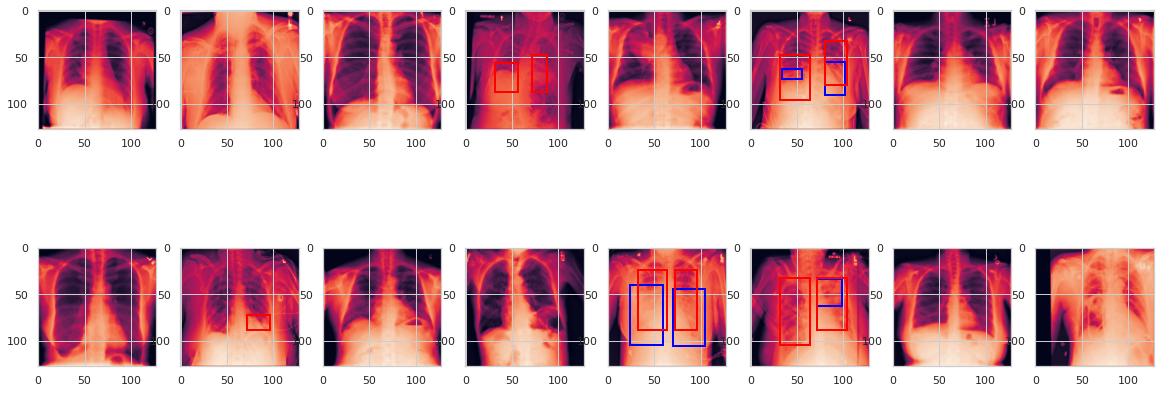

In [ ]:
for imgs, msks in valid_gen:
    # predict batch of images
    preds = model.predict(imgs)
    # create figure
    f, axarr = plt.subplots(2, 8, figsize=(20,8))
    axarr = axarr.ravel()
    axidx = 0
    # loop through batch
    for img, msk, pred in zip(imgs, msks, preds):
        # plot image
        axarr[axidx].imshow(img[:, :, 0])
        # threshold true mask
        comp = msk[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='b',facecolor='none'))
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='r',facecolor='none'))
        axidx += 1
    plt.show()
    # only plot one batch
    break

### Create network and compiler with SGD optimizer

Stochastic Gradient Descent (SGD) is a variant of gradient descent in which the parameter update
happens for every training example. Vanilla gradient descent computes the gradient of cost function
for entire training dataset before performing one update and SGD gets rid of this redundancy by
performing one update at a time.

Recent work shows that adaptive optimization techniques generalize much worse than
stochastic gradient descent (SGD) even when the solutions have better training performance. Here we train the model with SGD optimizer and compare the model performance with Adam optimizer in the validation set.

In [ ]:
model = create_network(input_size=128, channels=16, n_blocks=2, depth=3)
model.compile(optimizer='SGD',
              loss=iou_bce_loss,
              metrics=['accuracy', mean_iou])
print("model summary:", model.summary())

Add input shape: (None, 64, 64, 32)
Resnet block input shape: (None, 64, 64, 32)
Resnet block out shape: (None, 64, 64, 32)
concat block out shape: (None, 64, 64, 64)
mixed block out shape: (None, 64, 64, 32)
Add input shape: (None, 64, 64, 32)
Resnet block input shape: (None, 64, 64, 32)
Resnet block out shape: (None, 64, 64, 32)
concat block out shape: (None, 64, 64, 64)
mixed block out shape: (None, 64, 64, 32)
Add input shape: (None, 32, 32, 64)
Resnet block input shape: (None, 32, 32, 64)
Resnet block out shape: (None, 32, 32, 64)
concat block out shape: (None, 32, 32, 128)
mixed block out shape: (None, 32, 32, 64)
Add input shape: (None, 32, 32, 64)
Resnet block input shape: (None, 32, 32, 64)
Resnet block out shape: (None, 32, 32, 64)
concat block out shape: (None, 32, 32, 128)
mixed block out shape: (None, 32, 32, 64)
Add input shape: (None, 16, 16, 128)
Resnet block input shape: (None, 16, 16, 128)
Resnet block out shape: (None, 16, 16, 128)
concat block out shape: (None, 16, 

#### Fit the model

In [ ]:
history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate], epochs=10, shuffle=True, verbose=2)

Epoch 1/10
62/62 - 169s - loss: 0.8092 - accuracy: 0.6282 - mean_iou: 0.0281 - val_loss: 0.7822 - val_accuracy: 0.6986 - val_mean_iou: 0.0238
Epoch 2/10
62/62 - 166s - loss: 0.7596 - accuracy: 0.7424 - mean_iou: 0.0271 - val_loss: 0.7418 - val_accuracy: 0.7928 - val_mean_iou: 0.0199
Epoch 3/10
62/62 - 167s - loss: 0.7220 - accuracy: 0.8252 - mean_iou: 0.0248 - val_loss: 0.7085 - val_accuracy: 0.8557 - val_mean_iou: 0.0188
Epoch 4/10
62/62 - 168s - loss: 0.6937 - accuracy: 0.8789 - mean_iou: 0.0216 - val_loss: 0.6832 - val_accuracy: 0.9039 - val_mean_iou: 0.0147
Epoch 5/10
62/62 - 169s - loss: 0.6708 - accuracy: 0.9127 - mean_iou: 0.0193 - val_loss: 0.6596 - val_accuracy: 0.9331 - val_mean_iou: 0.0125
Epoch 6/10
62/62 - 168s - loss: 0.6533 - accuracy: 0.9344 - mean_iou: 0.0169 - val_loss: 0.6449 - val_accuracy: 0.9478 - val_mean_iou: 0.0120
Epoch 7/10
62/62 - 171s - loss: 0.6392 - accuracy: 0.9471 - mean_iou: 0.0212 - val_loss: 0.6316 - val_accuracy: 0.9586 - val_mean_iou: 0.0281
Epoch 

#### Plot the graphs

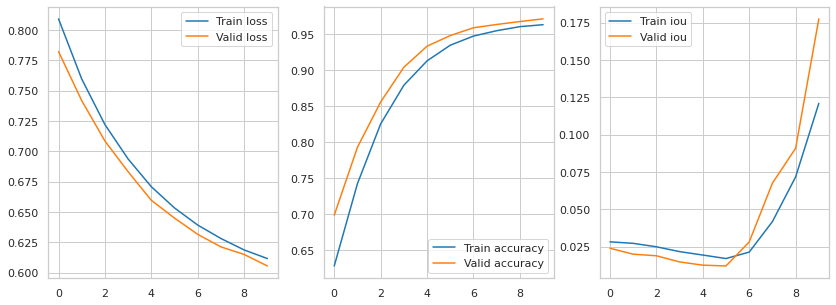

In [ ]:
plt.figure(figsize=(14,5))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["accuracy"], label="Train accuracy")
plt.plot(history.epoch, history.history["val_accuracy"], label="Valid accuracy")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["mean_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_mean_iou"], label="Valid iou")
plt.legend()
plt.show()

In [ ]:
sgd_accuracy = round(history.history.get('accuracy')[-1] * 100, 2)
sgd_val_accuracy = round(history.history.get('val_accuracy')[-1] * 100, 2)
sgd_loss = round(history.history.get('loss')[-1] * 100, 2)
sgd_val_loss = round(history.history.get('val_loss')[-1] * 100, 2)
sgd_mean_iou = round(history.history.get('mean_iou')[-1] * 100, 2)
sgd_val_mean_iou = round(history.history.get('val_mean_iou')[-1] * 100, 2)

print(sgd_accuracy, sgd_val_accuracy, sgd_loss, sgd_val_loss, sgd_mean_iou, sgd_val_mean_iou)

96.28 97.1 61.16 60.55 12.1 17.76


## Summary

In [ ]:
result = pd.DataFrame(
    {
        'Optimizer': ['ADAM', 'SGD '],
        'accuracy': [adm_accuracy,  sgd_accuracy],
        'val_accuracy': [adm_val_accuracy,  sgd_val_accuracy],
        'loss': [adm_loss, sgd_loss],
        'val_loss': [adm_val_loss, sgd_val_loss],
        'mean_iou': [adm_mean_iou, sgd_mean_iou],
        'val_mean_iou': [adm_val_mean_iou, sgd_val_mean_iou]
    })

result.sort_values(by=['accuracy', 'val_accuracy'], axis=0, ascending=True,
                    inplace=False, kind='quicksort', na_position='last')

result

Optimizer  accuracy  val_accuracy   loss  val_loss  mean_iou  val_mean_iou
0      ADAM    96.640        97.060 45.450    44.380    67.580        66.070
1      SGD     96.280        97.100 61.160    60.550    12.100        17.760

## Observations

* We have implemented a RESNET model from scratch, trained the model with Adam and SGD optimizers for comparison, and tested the model performance on the validation set.
* <b>The model has validation accuracy of 97.060% and 97.100%, and vaidation mean IOU of 66.070 and 17.760 for Adam and SGD optimizers respectively</b>, showing <b>Adam optimizer performing significantly better in this configuration</b>.
* Due to hardware constraints,the model was trained on a set of 2000 images randomly selected from the training set, and tested on a set of 200 images randomly selected from the validation set. 
* Due to same limitations, the model was trained with 10 epochs, the default keras batch size of 32 and learning rate of 0.001, as one epoch takes approximately 12 minutes to train in Google colab.   

## Suggesed Improvements

* The model needs to be tested on the test daset provided in order to find performance metrics (AUC) and understand how the model performs with new data.
* The model can be significantly improved with cross validation, hyperparameter tuning (finding optimal learning rate etc) and implementing classificaion ensemble pipelines.
* Image Augmentation techniques (Feature Standardization, ZCA whitening, Histogram Equalization, Adaptive Equalization) can be tested and implemented in order to improve the model performance and ability of the model to generalize. 